In [1]:
import torchvision.models as models
import torch.onnx as onnx
import torch

/opt/conda/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import matplotlib.pyplot as plt
from imutils import paths
import numpy as np
import random
import time
import PIL
import cv2
import os

In [3]:
from models.experimental import attempt_load
from utils.datasets import letterbox
from utils.general import check_img_size, non_max_suppression_face, apply_classifier, scale_coords, xywh2xyxy, xyxy2xywh, \
    strip_optimizer, set_logging, increment_path
from utils.plots import plot_one_box
from utils.torch_utils import select_device, load_classifier, time_synchronized

In [4]:
def make_dir(dirName):
    # Create a target directory & all intermediate 
    # directories if they don't exists
    
    if not os.path.exists(dirName):
        os.makedirs(dirName, exist_ok = True)
        print("[INFO] Directory " ,dirName,  " created")
    else:
        print("[INFO] Directory " ,dirName,  " already exists") 

In [5]:
def scale_coords_landmarks(img1_shape, coords, img0_shape, ratio_pad=None):
    # Rescale coords (xyxy) from img1_shape to img0_shape
    
    if ratio_pad is None:  # calculate from img0_shape
        gain = min(img1_shape[0] / img0_shape[0], img1_shape[1] / img0_shape[1])  # gain  = old / new
        pad = (img1_shape[1] - img0_shape[1] * gain) / 2, (img1_shape[0] - img0_shape[0] * gain) / 2  # wh padding
    else:
        gain = ratio_pad[0][0]
        pad = ratio_pad[1]

    coords[:, [0, 2, 4, 6, 8]] -= pad[0]  # x padding
    coords[:, [1, 3, 5, 7, 9]] -= pad[1]  # y padding
    coords[:, :10] /= gain
    coords[:, 0].clamp_(0, img0_shape[1])  # x1
    coords[:, 1].clamp_(0, img0_shape[0])  # y1
    coords[:, 2].clamp_(0, img0_shape[1])  # x2
    coords[:, 3].clamp_(0, img0_shape[0])  # y2
    coords[:, 4].clamp_(0, img0_shape[1])  # x3
    coords[:, 5].clamp_(0, img0_shape[0])  # y3
    coords[:, 6].clamp_(0, img0_shape[1])  # x4
    coords[:, 7].clamp_(0, img0_shape[0])  # y4
    coords[:, 8].clamp_(0, img0_shape[1])  # x5
    coords[:, 9].clamp_(0, img0_shape[0])  # y5
    
    return coords

In [6]:
def show_det(img, xywh, conf):
    # Draw detected bounding boxes

    h,w,c = img.shape
    
    tl = 1 or round(0.01 * (h + w) / 2) + 1  # line/font thickness

    # Convert YOLO coordinates to x1, y1, x2, y2 format
    x1 = int(xywh[0] * w - 0.5 * xywh[2] * w)
    y1 = int(xywh[1] * h - 0.5 * xywh[3] * h)
    x2 = int(xywh[0] * w + 0.5 * xywh[2] * w)
    y2 = int(xywh[1] * h + 0.5 * xywh[3] * h)

    # Draw detected bounding box
    cv2.rectangle(img, (x1,y1), (x2, y2), (0,0,255), thickness=tl, lineType=cv2.LINE_AA)

    # Put confidence threshold
    tf = max(tl - 1, 1)  # font thickness
    label = str(conf)[:5]
    cv2.putText(img, label, (x1, y1 - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)
    
    return img

In [7]:
def detect(model, image_path, save_path, device, imgsz=640, conf_thres=0.5, iou_thres=0.5, augment=None, feature_vis=False, save=True, show=False):
    # Detect face region and facial landmarks on given images

    # Load image and create a copy
    orgimg = cv2.imread(image_path)
    img0 = orgimg.copy()
    
    # Preprocess the image     
    stride = int(model.stride.max())    
    if imgsz <= 0:                    
        imgsz = dynamic_resize(img0.shape)
    imgsz = check_img_size(imgsz, s=64)
    img = letterbox(img0, imgsz)[0]
    img = img[:, :, ::-1].transpose(2, 0, 1)
    img = np.ascontiguousarray(img)
    img = torch.from_numpy(img).to(device)
    img = img.float()
    img /= 255.0
    if img.ndimension() == 3:
        img = img.unsqueeze(0)

    # Inference
    if augment is not None:
        pred = model(img, augment=True, aug_setting=augment, feature_vis=feature_vis)[0]
    else:
        pred = model(img, augment=False, feature_vis=feature_vis)[0]
        
        
    # Apply non max suppression
    pred = non_max_suppression_face(pred, conf_thres, iou_thres)[0]
    gn = torch.tensor(img0.shape)[[1, 0, 1, 0]].to(device)                        # normalization gain whwh
    gn_lks = torch.tensor(img0.shape)[[1, 0, 1, 0, 1, 0, 1, 0, 1, 0]].to(device)  # normalization gain landmarks
    
    # Scale and store predictions
    boxes = []
    landmarks = []
    conf_scores = []
    h, w, c = img0.shape
    if pred is not None:
        pred[:, :4] = scale_coords(img.shape[2:], pred[:, :4], img0.shape).round()
        pred[:, 5:15] = scale_coords_landmarks(img.shape[2:], pred[:, 5:15], img0.shape).round()
        for j in range(pred.size()[0]):
            xywh = (xyxy2xywh(pred[j, :4].view(1, 4)) / gn).view(-1)
            xywh = xywh.data.cpu().numpy()
            conf = pred[j, 4].cpu().numpy()
            points = (pred[j, 5:15].view(1, 10) / gn_lks).view(-1).tolist()
            class_num = pred[j, 15].cpu().numpy()
            x1 = int(xywh[0] * w - 0.5 * xywh[2] * w)
            y1 = int(xywh[1] * h - 0.5 * xywh[3] * h)
            x2 = int(xywh[0] * w + 0.5 * xywh[2] * w)
            y2 = int(xywh[1] * h + 0.5 * xywh[3] * h)
                
            boxes.append([x1, y1, x2-x1, y2-y1])
            landmarks.append(points)
            conf_scores.append(conf)
            
            # Draw detected bounding box
            orgimg = show_det(orgimg, xywh, conf)
         
    # Save the image
    img = PIL.Image.fromarray(cv2.cvtColor(orgimg, cv2.COLOR_BGR2RGB))
    if save:
        img.save(os.path.join(save_path, image_path.split("/")[-1]))
    
    if show:
        img.show()
        
    return boxes, landmarks, conf_scores

In [11]:
exp_id = 999              # experiment ID
iou_thres = 0.5           # IoU threshold
conf_thres = 0.02         # confidence threshold
img_size = 1280           # image size used at evaluation

test_path = '/workspace/test_images/random_images'          # directory of the test images
save_path = "/workspace/yolov5-face/test_images_results/random_images"    # directory where images with detections get saved
make_dir(save_path)

# Get paths to the test images
test_images = list(paths.list_images(test_path))

[INFO] Directory  /workspace/yolov5-face/test_images_results/random_images  created


In [9]:
# Load weights 
weights = "/workspace/yolov5-face-my/runs/train/exp1_l6/weights/best.pt"    # path to the model weights
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
model = attempt_load(weights, map_location=device)

Fusing layers... 
None


1


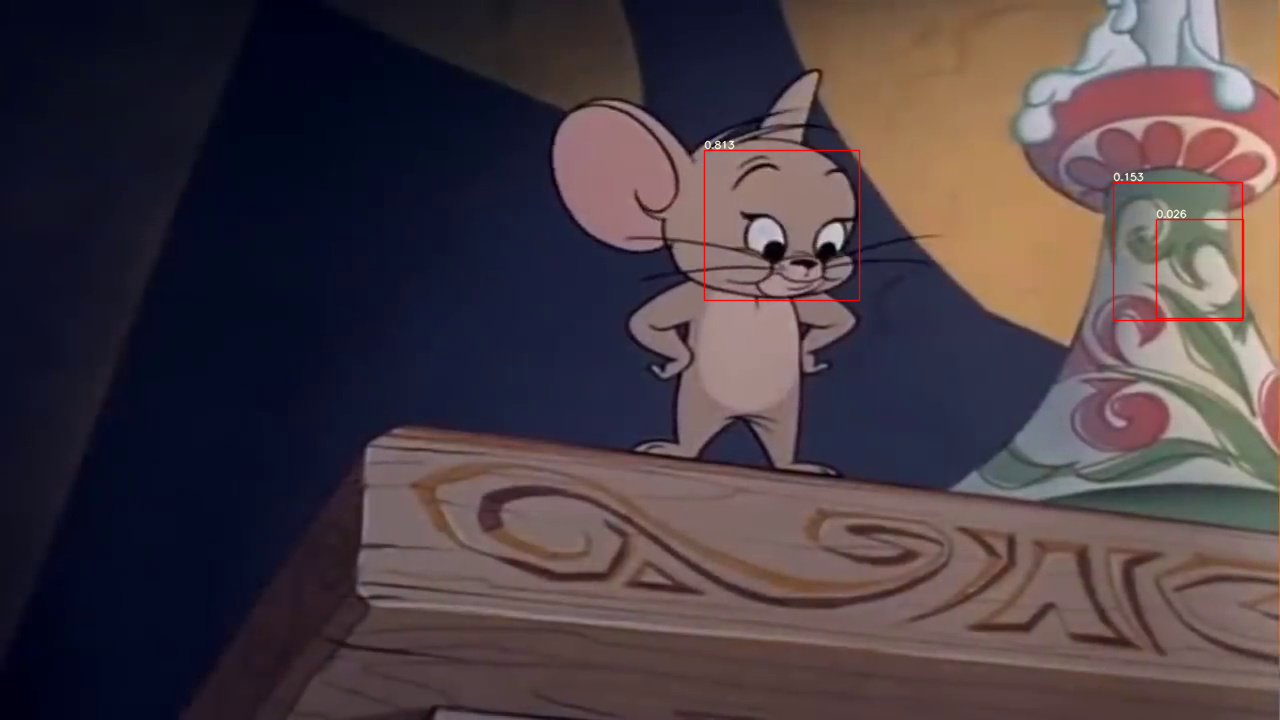

([[704, 150, 155, 150], [1113, 182, 129, 138], [1156, 219, 87, 99]],
 [[0.3968749940395355,
   0.18333333730697632,
   0.4312500059604645,
   0.18472221493721008,
   0.41874998807907104,
   0.2222222238779068,
   0.39921873807907104,
   0.23749999701976776,
   0.4234375059604645,
   0.24027778208255768],
  [0.60546875,
   0.20416666567325592,
   0.637499988079071,
   0.20555555820465088,
   0.629687488079071,
   0.22638888657093048,
   0.6148437261581421,
   0.25555557012557983,
   0.6351562738418579,
   0.2569444477558136],
  [0.936718761920929,
   0.3638888895511627,
   0.9546874761581421,
   0.3513889014720917,
   0.957812488079071,
   0.39444443583488464,
   0.944531261920929,
   0.4138889014720917,
   0.956250011920929,
   0.4069444537162781]],
 [array(    0.81374, dtype=float32),
  array(    0.15331, dtype=float32),
  array(   0.026131, dtype=float32)])

In [10]:
# Show an image with detected bounding boxes
detect(model, test_images[0], save_path, device, img_size, conf_thres, iou_thres, 1, feature_vis=True, save=False, show=True)

In [12]:
# Save test images with detected bounding boxes
for i in range(len(test_images)):
    detect(model, test_images[i], save_path, device, img_size, conf_thres, iou_thres, 2, feature_vis=False, save=True, show=False)

2
2
2
2
2
2
2
2
2
2
